In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [ ]:
data = pd.read_csv('data/interaction_data.csv')

In [ ]:
data.head()

,ID1,ID2,time,type1,type2
0,1157,1232,140,3,4
1,1157,1191,160,3,3
2,1157,1159,500,3,3
3,1157,1159,520,3,3
4,1159,1191,560,3,3


In [ ]:
# make ID to job dictionary
# 1 = NUR/paramedical staff, i.e. nurses and nurses’ aides; 
# 2 = PAT/Patient; 
# 3 = MED/Medical doctor; 
# 4 = ADM/administrative staff

ID_job = {}
for _, row in data.iterrows():
    ID_job[row['ID1']] = row['type1']
    ID_job[row['ID2']] = row['type2']
assert len(ID_job.keys())==75, 'wrong number of IDs'

In [ ]:
## removing nurse-patient interaction Uncomment next line to remove all nurses patients interactions
# data = data[~(((data['type1']==1) & (data['type2']==2))|((data['type1']==2) & (data['type2']==1)))]

In [ ]:
data = data.drop(columns = ['type1', 'type2'])

In [ ]:
# discretizing the time
# make the time unit 1 minute
data['time'] = data['time']//60

In [ ]:
data.shape

(32424, 3)

In [ ]:
# map every ID to an index
nurses = []
doctors = []
patients = []
admins = []
ID_idx = {}
idx_ID = {}
idx_job = {}
for i, j in enumerate(list(ID_job.keys())):
    ID_idx[j] = i
    idx_ID[i] = j
    idx_job[i] = ID_job[j]
    if ID_job[j] == 1:
        nurses.append(i)
    if ID_job[j] == 2:
        patients.append(i)
    if ID_job[j] == 3:
        doctors.append(i)
    if ID_job[j] == 4:
        admins.append(i)
print(f'number of nurses = {len(nurses)}')
print(f'number of doctors = {len(doctors)}')
print(f'number of patients = {len(patients)}')
print(f'number of admins = {len(admins)}')

number of nurses = 27
number of doctors = 11
number of patients = 29
number of admins = 8


In [ ]:
data2 = data.set_index('time')
timesteps = np.unique(list(data2.index))

In [ ]:
data2.head()

,ID1,ID2
time,,
2,1157,1232
2,1157,1191
8,1157,1159
8,1157,1159
9,1159,1191


In [ ]:
# convert IDs into idxs
data2['ID1'] = data2['ID1'].apply(lambda x: ID_idx[x])
data2['ID2'] = data2['ID2'].apply(lambda x: ID_idx[x])

In [ ]:
data2.head()

,ID1,ID2
time,,
2,0,1
2,0,2
8,0,3
8,0,3
9,3,2


In [ ]:
# defining parameters

gamma_shape = 3

# relaxation times
exposed_time = 60 * 24 * 2 / gamma_shape # gamma_shape is the shape of the gamma distribution where mean = shape*scale
latent_time = 60 * 24 * 5 / gamma_shape
infected_undetected_time = 60 * 24 * 12 / gamma_shape
infected_time = 60 * 24 * 7 / gamma_shape

undetected_ratio = 0.8  # ratio of undetected infected cases


In [ ]:
## states:
##  0 : Susceptible
##  1 : Exposed
##  2 : Latent
##  3 : Infected, We will treat him as removed from population
##  4 : Infected_undetected
##  5 : Recovered
##  6 : removed, not needed if we treat infected as removed

def run_simulation(beta, simulation_days, initial_state=None, verbose=True, debug=False):
  beta1 = beta
  beta2 = beta

  state = initial_state if initial_state is not None else np.zeros(len(ID_job.keys()))
  infected_seed = np.random.choice(nurses)
  state[infected_seed] = 1
  print('infected seed ID =', idx_ID[infected_seed])
  print('infected seed index =', infected_seed)
  if debug:
    print(state)

  time_vector = np.full_like(state, -1)
  time_vector[infected_seed] = np.random.gamma(gamma_shape, exposed_time)

  R0_vector = np.zeros_like(state)

  # propagation model
  observations = [state.copy()]
  time_counter = np.zeros_like(state)
  max_simulation_times = int(np.ceil(simulation_days/5))
  tt = 0
  for t in range(1, (max_simulation_times*max(timesteps)) + 1):
      t = t % (max(timesteps)+1)
      tt += 1
      
      # getting the contact data at this timestep
      connections = data2.loc[t].values.reshape(-1,2) if t in timesteps else []
      
      # incrementing time counter
      time_counter += 1
      
      # Extracting the indices of different states
      susceptible = np.argwhere(state==0).reshape(-1)
      exposed = np.argwhere(state==1).reshape(-1)
      latent = np.argwhere(state==2).reshape(-1)
      infected = np.argwhere(state==3).reshape(-1)
      infected_undetected = np.argwhere(state==4).reshape(-1)
      recovered = np.argwhere(state==5).reshape(-1)
      
      # adding static probabilities (static means probabilities applied at each timestep)
      probs = np.zeros_like(state)
      infected_by = [[] for _ in range(len(state))]
      
      # adding contact based probabilities 
      for i, j in connections:
          if (state[i]==state[j]):
              continue
          elif (i in susceptible):
              if (j in latent):
                  probs[i] += beta1
                  infected_by[i].append(j)
              elif (j in infected_undetected):
                  probs[i] += beta2
                  infected_by[i].append(j)
              elif (j in infected):
                  probs[i] += beta2
                  infected_by[i].append(j)
          elif (j in susceptible):
              if (i in latent):
                  probs[j] += beta1
                  infected_by[j].append(i)
              elif (i in infected_undetected):
                  probs[j] += beta2
                  infected_by[j].append(i)
              elif (i in infected):
                  probs[j] += beta2
                  infected_by[j].append(i)
              
      # updating the state vector
      for i in range(len(state)):
          s = state[i]
          prob = probs[i]
          if (i in susceptible):
              s = np.random.choice([1, 0], p = [prob, 1-prob])
              if state[i] != s:
                  time_vector[i] = np.random.gamma(gamma_shape, exposed_time)
                  time_counter[i] = 0
                  for ii in infected_by[i]:
                      R0_vector[ii] += 1/len(infected_by[i])
          if (i in exposed):
              if time_vector[i] <= time_counter[i]:
                  s = 2
                  time_vector[i] = np.random.gamma(gamma_shape, latent_time)
                  time_counter[i] = 0
          if (i in latent):
              if time_vector[i] <= time_counter[i]:
                  if (np.random.rand() <= undetected_ratio):
                      s = 4 
                      time_vector[i] = np.random.gamma(gamma_shape, infected_undetected_time)
                      time_counter[i] = 0
                  else:
                      s = 3 
                      time_vector[i] = np.random.gamma(gamma_shape, infected_time)
                      time_counter[i] = 0
          if (i in infected_undetected):
              if time_vector[i] <= time_counter[i]:
                  s = 5 
                  time_vector[i] = -1
                  time_counter[i] = 0
          if (i in infected):
              if time_vector[i] <= time_counter[i]:
                  s = 5 
                  time_vector[i] = -1
                  time_counter[i] = 0
                  
          state[i] = s
      
      if tt%60 == 0:
          observations.append(state.copy())
      
      carriers = np.sum(exposed>=0) + np.sum(latent>=0) + np.sum(infected>=0) + np.sum(infected_undetected>=0)

      if (tt%(12*60) == 0) and verbose:
          print(f'Day {tt/(24*60):.1f}:')
          print('-'*8)
          print(f'total number of exposed = {np.sum(exposed>=0)}')
          print(f'total number of latent = {np.sum(latent>=0)}')
          print(f'total number of undetected infected = {np.sum(infected_undetected>=0)}')
          print(f'total number of detected infected = {np.sum(infected>=0)}')
          print(f'total number of recovered = {np.sum(recovered>=0)}')
          print(f'total number of susceptible = {np.sum(susceptible>=0)}')
          print(f'total number of carriers = {np.sum(carriers)}')
          print('#'*50)

      if (carriers == 0) or (np.sum(susceptible>=0)==0):
        print(f'simulation reached stable state after {tt/(24*60):.0f} days')
        observations.append(state.copy())
        break

  observations = np.array(observations).T
  R0 = R0_vector[infected_seed]

  return observations, R0_vector, R0

In [ ]:
nurses_IDs = [1115, 1210, 1295, 1207, 1193, 1164]

############################################################
Removing top 3 nurses and 2 Doctors
trial 1:
--------
infected seed ID = 1109
infected seed index = 8
simulation reached stable state after 81 days
CPU times: user 6min 41s, sys: 1.22 s, total: 6min 43s
Wall time: 6min 44s
Final susceptible number = 22
R0 = 1.0
trial 2:
--------
infected seed ID = 1207
infected seed index = 43
simulation reached stable state after 71 days
CPU times: user 5min 44s, sys: 1.17 s, total: 5min 46s
Wall time: 5min 47s
Final susceptible number = 17
R0 = 8.999999999999998
trial 3:
--------
infected seed ID = 1245
infected seed index = 46
simulation reached stable state after 92 days
CPU times: user 8min 12s, sys: 1.67 s, total: 8min 14s
Wall time: 8min 16s
Final susceptible number = 31
R0 = 1.0
trial 4:
--------
infected seed ID = 1142
infected seed index = 16
simulation reached stable state after 117 days
CPU times: user 9min 41s, sys: 1.91 s, total: 9min 43s
Wall time: 9min 46s
Final susceptible nu

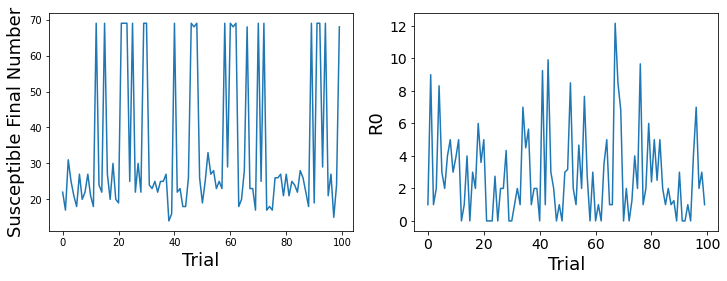

CPU times: user 9h 6min 44s, sys: 1min 52s, total: 9h 8min 37s
Wall time: 9h 9min 42s


In [ ]:
# Experiment 0
%%time
beta = 0.0012
num_iterations = 100
nurses_original = np.copy(nurses)
removed_nurses = np.array([ID_idx[nid] for nid in nurses_IDs[:3]])
print('#'*60)
print(f'Removing top 3 nurses and 2 Doctors')
beta_observations = []
beta_susceptible = []
beta_final_state = []
beta_R0 = []

# setting initial state
nurses = np.copy(nurses_original)
initial_state = np.zeros(len(ID_job.keys()))
initial_state[removed_nurses] = 6
for rn in removed_nurses:
  nurses = nurses[nurses!=rn]

for i in range(num_iterations):
  print(f'trial {i+1}:')
  print('-'*8)

  removed_doctors = np.random.choice(doctors, size = 2, replace = False)
  initial_state2 = np.copy(initial_state)
  initial_state2[removed_doctors] = 6

  %time observations, _, R0 = run_simulation(beta, simulation_days=400, initial_state=np.copy(initial_state2), verbose=False, debug=False)
  
  beta_observations.append(observations)
  beta_final_state.append(observations[:, -1])
  beta_susceptible.append(np.sum(observations[:,-1]==0))
  beta_R0.append(R0)
  print(f'Final susceptible number = {np.sum(observations[:,-1]==0)}')
  print(f'R0 = {R0}')
  print('='*50)

print(f'Mean Susceptible = {np.mean(beta_susceptible)}')
print(f'Mean R0 = {np.mean(beta_R0)}')

with open(f'results/remove_32/observations_{beta}.pkl', 'wb') as f:
    pickle.dump(beta_observations, f)
with open(f'results/remove_32/final_state_{beta}.pkl', 'wb') as f:
    pickle.dump(beta_final_state, f)
with open(f'results/remove_32/R0_{beta}.pkl', 'wb') as f:
    pickle.dump(beta_R0, f)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(beta_susceptible)
plt.xlabel('Trial', fontsize=18)
plt.ylabel('Susceptible Final Number', fontsize=18)
plt.subplot(1,2,2)
plt.plot(beta_R0)
plt.xlabel('Trial', fontsize=18)
plt.ylabel('R0', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()